# Emmanuel Akanbi <br> LDA Uber Analysis Final Project


# Loading the Data and Importing Libraries

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import operator
import warnings
from datetime import datetime, date
import haversine as hs
from haversine import Unit
from sklearn.neighbors import NearestCentroid
warnings.filterwarnings("ignore")
%matplotlib inline
from geopy.geocoders import Nominatim
import re
import calendar

In [102]:
uber = pd.read_csv("uber.csv")
uber.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [103]:
uber.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [104]:
uber = uber.drop(['Unnamed: 0', 'key'], axis = 1)

In [105]:
uber.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [106]:
uber.shape

(200000, 7)

## Cleaning and Initial Exploration

In [107]:
uber.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [108]:
#only one with passenger count over 6 may drop
uber_passenger_count_over_6 = uber[uber["passenger_count"]>6]
uber_passenger_count_over_6

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113038,11.7,2010-12-28 08:20:00 UTC,-73.937795,40.758498,-73.937835,40.758415,208


In [109]:
uber_null_lat = uber[uber["pickup_latitude"].isnull()]
print(uber_null_lat)
uber_null_lon = uber[uber["pickup_longitude"].isnull()]
print(uber_null_lon)

Empty DataFrame
Columns: [fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count]
Index: []
Empty DataFrame
Columns: [fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count]
Index: []


In [110]:
uber = uber.dropna(axis=0)
uber.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [111]:
uber = uber[uber["passenger_count"]!=208]
uber.shape

(199998, 7)

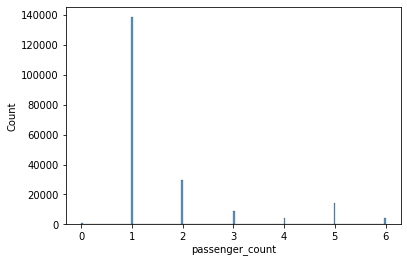

In [112]:
sns.histplot(uber, x="passenger_count")
plt.show()

In [113]:
uber.shape

(199998, 7)

In [114]:
#some latitude and longitude points were not in range
uber_cleaned = uber[((uber["pickup_latitude"] >= -90) & (uber["pickup_latitude"] <= 90)) &
((uber["dropoff_latitude"] >= -90) & (uber["dropoff_latitude"] <= 90)) &
((uber["pickup_longitude"] >= -180) & (uber["pickup_longitude"] <= 180)) &
((uber["dropoff_longitude"] >= -180) & (uber["dropoff_longitude"] <= 180))
]

In [115]:
#some fare_amounts less than 0
uber_cleaned=uber_cleaned[uber_cleaned["fare_amount"]>0]

In [116]:
uber_cleaned = uber_cleaned[uber_cleaned["pickup_longitude"]!=0]

In [117]:
uber_cleaned.shape

(196179, 7)

In [118]:
uber_cleaned.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,196179.000000,196179.000000,196179.000000,196179.000000,196179.000000,196179.000000
mean,11.349921,-73.900813,40.686754,-73.836550,40.651476,1.684161
std,9.807117,2.814148,2.650586,3.545197,2.908971,1.307714
min,0.010000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000
25%,6.000000,-73.992268,40.736392,-73.991582,40.735190,1.000000
50%,8.500000,-73.982101,40.753281,-73.980500,40.753700,1.000000
75%,12.500000,-73.968310,40.767536,-73.965220,40.768312,2.000000
max,499.000000,40.808425,48.018760,40.831932,45.031598,6.000000


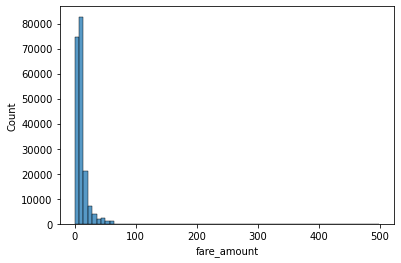

In [119]:
sns.histplot(uber_cleaned,x="fare_amount", bins=70)
plt.show()

The fare_amount variable is right skew. Will need to transform

# Functions

In [120]:
# calculate the distance from pick up to drop off points
def distance (initial_latitude,initial_longitude,final_latitude,final_longitude):
    loc1 = (initial_latitude,initial_longitude)
    loc2 = (final_latitude,final_longitude)
    dist = hs.haversine(loc1,loc2, unit=Unit.MILES)
    return dist


In [121]:
#extracting the hour
def hour (date):
    x = datetime.strptime(date, '%Y-%m-%d %H:%M:%S %Z')
    return x.hour

In [122]:
#extracting the dat of the week
def weekday(date):
    x = datetime.strptime(date, '%Y-%m-%d %H:%M:%S %Z')
    return x.strftime("%A")


In [123]:
#extracting the month
def month(date):
    x = datetime.strptime(date, '%Y-%m-%d %H:%M:%S %Z')
    month_num = x.month
    month_name = calendar.month_abbr[month_num]
    return month_name


In [124]:
#extracting the year
def year(date):
    x = datetime.strptime(date, '%Y-%m-%d %H:%M:%S %Z')
    return x.year 

In [125]:
def confusion_matrix(true, pred):
    confusion_matrix =  pd.crosstab(index = true, columns=pred.ravel(), rownames=['Expected'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
    plt.title("Classification Matrix Test Set", fontsize = 15)
    plt.show()

## Feature Creation

In [126]:
#calculate distance traveled
uber_cleaned["distance(mi)"] = uber_cleaned.apply(lambda x: distance(x["pickup_latitude"], x["pickup_longitude"], 
x["dropoff_latitude"],x["dropoff_longitude"]), axis =1)

#fare per distance
uber_cleaned["fare_per_distance"] = round(uber_cleaned["fare_amount"]/uber_cleaned["distance(mi)"],2)
uber_cleaned.head()

#extract year
uber_cleaned["year"] = uber_cleaned["pickup_datetime"].apply(year)

#extract month
uber_cleaned["month"] = uber_cleaned["pickup_datetime"].apply(month)


# extract day of the week
uber_cleaned["day_of_week"] = uber_cleaned["pickup_datetime"].apply(weekday)


#extract hour
uber_cleaned["hour"] = uber_cleaned["pickup_datetime"].apply(hour)
uber_cleaned.head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance(mi),fare_per_distance,year,month,day_of_week,hour
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.045970,7.17,2015,May,Thursday,19
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,1.527078,5.04,2009,Jul,Friday,20
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,3.129464,4.12,2009,Aug,Monday,21
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.032524,5.13,2009,Jun,Friday,8
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,2.780920,5.75,2014,Aug,Thursday,17
5,4.9,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,inf,2011,Feb,Saturday,2
6,24.5,2014-10-12 07:04:00 UTC,-73.961447,40.693965,-73.871195,40.774297,5,7.289325,3.36,2014,Oct,Sunday,7
8,9.7,2012-02-17 09:32:00 UTC,-73.975187,40.745767,-74.002720,40.743537,1,1.449481,6.69,2012,Feb,Friday,9
9,12.5,2012-03-29 19:06:00 UTC,-74.001065,40.741787,-73.963040,40.775012,1,3.038147,4.11,2012,Mar,Thursday,19
10,6.5,2015-05-22 17:32:27 UTC,-73.974388,40.746952,-73.988586,40.729805,1,1.398620,4.65,2015,May,Friday,17


In [127]:
uber_cleaned.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance(mi),fare_per_distance,year,hour
count,196179.000000,196179.000000,196179.000000,196179.000000,196179.000000,196179.000000,196179.000000,196179.00,196179.000000,196179.000000
mean,11.349921,-73.900813,40.686754,-73.836550,40.651476,1.684161,7.565867,inf,2011.740691,13.490980
std,9.807117,2.814148,2.650586,3.545197,2.908971,1.307714,166.337433,NaN,1.858772,6.514166
min,0.010000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,0.000000,0.00,2009.000000,0.000000
25%,6.000000,-73.992268,40.736392,-73.991582,40.735190,1.000000,0.780613,4.79,2010.000000,9.000000
50%,8.500000,-73.982101,40.753281,-73.980500,40.753700,1.000000,1.341699,6.18,2012.000000,14.000000
75%,12.500000,-73.968310,40.767536,-73.965220,40.768312,2.000000,2.434273,8.22,2013.000000,19.000000
max,499.000000,40.808425,48.018760,40.831932,45.031598,6.000000,5411.052633,inf,2015.000000,23.000000


## More Cleaning

In [128]:
#about 2000 records have a distance of 0
#700 records have 0 passengers
print(f"{len(uber_cleaned[uber_cleaned['distance(mi)']<=0])} records that have a distance of less than or equal to 0")
print(f"{len(uber_cleaned[uber_cleaned['passenger_count']<=0])} records that has a passenger count less than or equal to 0")

2044 records that have a distance of less than or equal to 0
688 records that has a passenger count less than or equal to 0


In [129]:
uber_cleaned = uber_cleaned[uber_cleaned['distance(mi)']>=0.1]
uber_cleaned = uber_cleaned[uber_cleaned['passenger_count']>=1]
uber_cleaned.shape

(191930, 13)

In [130]:
uber_cleaned.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance(mi),fare_per_distance,year,hour
count,191930.000000,191930.000000,191930.000000,191930.000000,191930.000000,191930.000000,191930.000000,191930.000000,191930.000000,191930.000000
mean,11.335231,-73.902558,40.687247,-73.837650,40.651611,1.690752,7.670356,7.160029,2011.749805,13.495983
std,9.525177,2.794481,2.639436,3.536152,2.901330,1.306267,167.266512,7.321416,1.861982,6.514339
min,0.010000,-93.824668,-74.015515,-75.458979,-74.015750,1.000000,0.100190,0.000000,2009.000000,0.000000
25%,6.000000,-73.992278,40.736470,-73.991587,40.735264,1.000000,0.807764,4.770000,2010.000000,9.000000
50%,8.500000,-73.982138,40.753290,-73.980557,40.753722,1.000000,1.366502,6.120000,2012.000000,14.000000
75%,12.500000,-73.968520,40.767556,-73.965512,40.768327,2.000000,2.470489,8.060000,2013.000000,19.000000
max,230.000000,40.808425,48.018760,40.831932,42.464187,6.000000,5411.052633,963.250000,2015.000000,23.000000


In [131]:
# creating the log of fare_amount and fare rate
uber_cleaned["log_fare_per_distance"] = np.log(uber_cleaned["fare_per_distance"])
uber_cleaned["log_fare_amount"] = np.log(uber_cleaned["fare_amount"])

In [132]:
uber_cleaned.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance(mi),fare_per_distance,year,month,day_of_week,hour,log_fare_per_distance,log_fare_amount
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.045970,7.17,2015,May,Thursday,19,1.969906,2.014903
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,1.527078,5.04,2009,Jul,Friday,20,1.617406,2.041220
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,3.129464,4.12,2009,Aug,Monday,21,1.415853,2.557227
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.032524,5.13,2009,Jun,Friday,8,1.635106,1.667707
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,2.780920,5.75,2014,Aug,Thursday,17,1.749200,2.772589


# Data Explorations

<AxesSubplot: xlabel='fare_amount', ylabel='distance(mi)'>

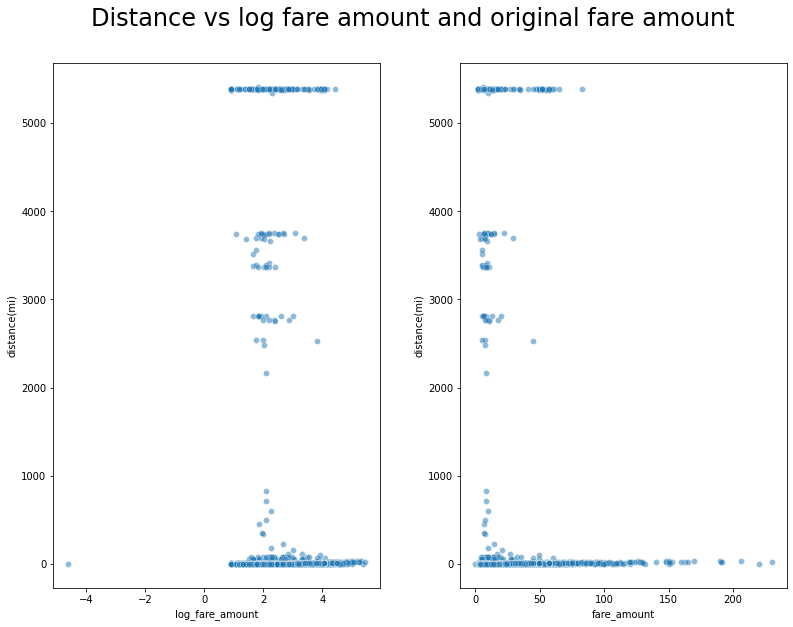

In [133]:
fig, ax = plt.subplots(1,2, figsize =(12,10))
fig.suptitle('Distance vs log fare amount and original fare amount', fontsize=24, y=0.9)
fig.tight_layout(pad=5.0)

sns.scatterplot(uber_cleaned, x="log_fare_amount", y="distance(mi)", alpha=0.5,
                ax=ax[0])
sns.scatterplot(uber_cleaned, x="fare_amount", y="distance(mi)", alpha=0.5,
                ax=ax[1])

<AxesSubplot: xlabel='fare_amount', ylabel='Count'>

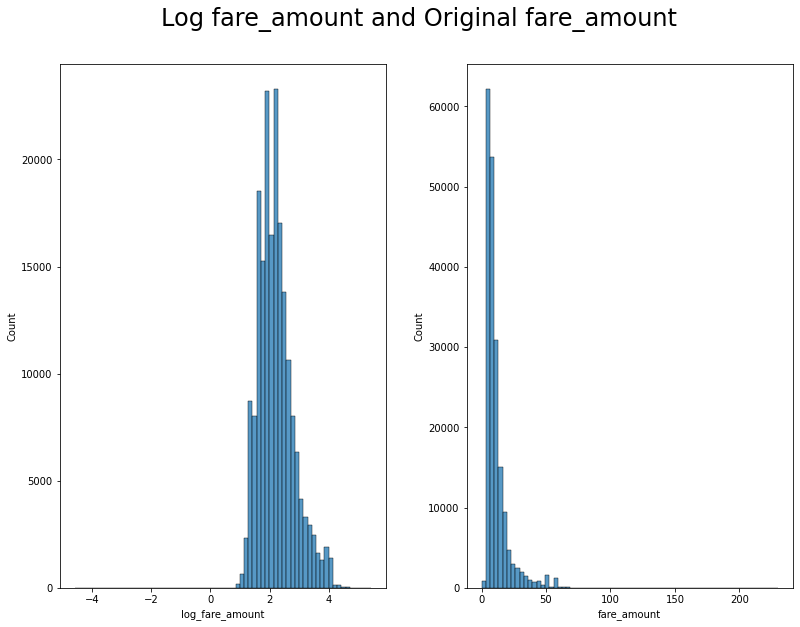

In [134]:
fig, ax = plt.subplots(1,2, figsize =(12,10))
fig.suptitle("Log fare_amount and Original fare_amount", fontsize=24, y=0.9)
fig.tight_layout(pad=5.0)

sns.histplot(uber_cleaned, x="log_fare_amount", bins=70, ax=ax[0])
sns.histplot(uber_cleaned, x = "fare_amount", bins=70, ax=ax[1])

The log of the fare_amount has a better distribution

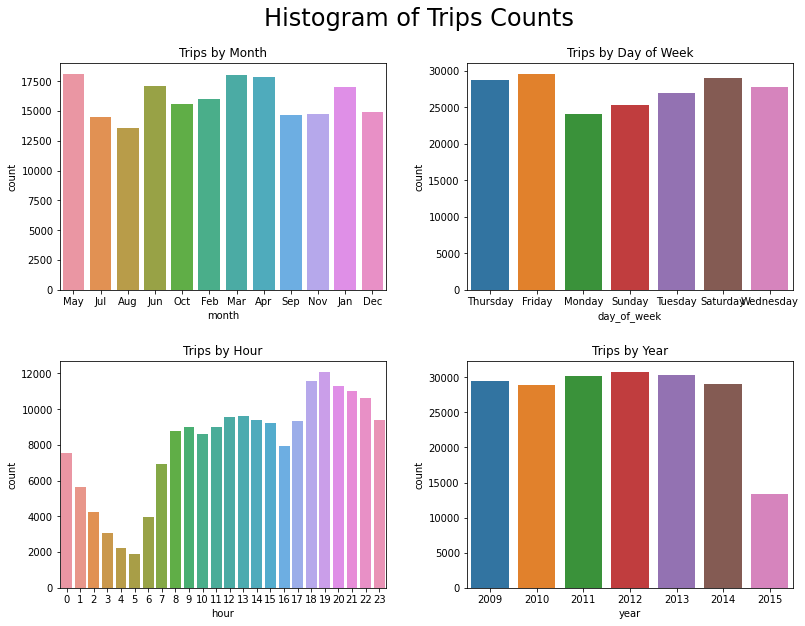

In [135]:
fig, ax = plt.subplots(2,2, figsize =(12,10))
fig.suptitle('Histogram of Trips Counts', fontsize=24, y=0.9)
fig.tight_layout(pad=5.0)

sns.countplot(uber_cleaned, x = "month", ax=ax[0,0], ).set(title = "Trips by Month")
sns.countplot(uber_cleaned, x="day_of_week", ax=ax[0,1]).set(title = "Trips by Day of Week")
sns.countplot(uber_cleaned, x="hour", ax=ax[1,0]).set(title = "Trips by Hour")
sns.countplot(uber_cleaned, x="year", ax=ax[1,1]).set(title = "Trips by Year")


plt.show()

Majority of the record are fairly distributed across the diffrent points in time

<AxesSubplot: >

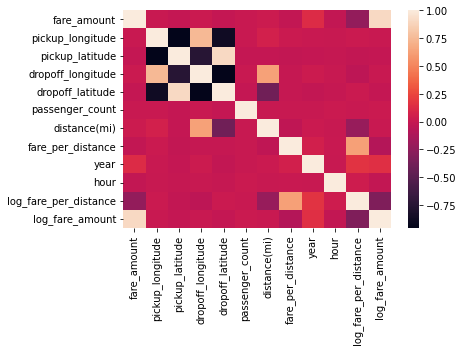

In [136]:
sns.heatmap(uber_cleaned.corr())

### Plot Trips by Location

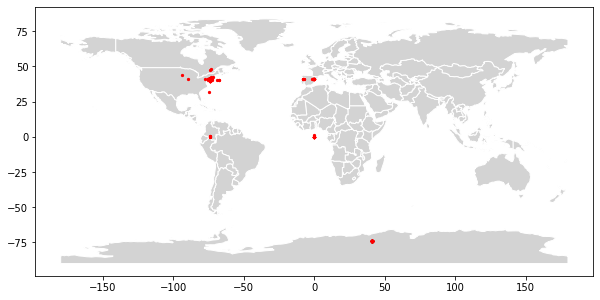

In [137]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry_pickup = [Point(xy) for xy in zip(uber_cleaned.pickup_longitude, uber_cleaned.pickup_latitude)]
geometry_dropoff = [Point(xy) for xy in zip(uber_cleaned.dropoff_longitude, uber_cleaned.dropoff_latitude)]

gdf = GeoDataFrame(uber_cleaned, geometry=geometry_pickup)   
gdf.plot(ax=world.plot(figsize=(10, 6), linewidth=1, edgecolor='white', color='lightgrey'), marker='o', color='red', markersize=5);


Here we see the location for each record based off of the pick up variables. The points within the United States will be the main focus 

In [138]:
# Remove data with invalid location information
uber_usa = uber_cleaned.copy()
uber_usa = uber_usa[(uber_usa['pickup_latitude'] > 20) & (uber_usa['pickup_latitude'] < 55)]
uber_usa = uber_usa[(uber_usa['dropoff_latitude'] > 20) & (uber_usa['dropoff_latitude'] < 55)]
uber_usa = uber_usa[(uber_usa['pickup_longitude'] > -125) & (uber_usa['pickup_longitude'] < -50)]
uber_usa = uber_usa[(uber_usa['dropoff_longitude'] > -125) & (uber_usa['dropoff_longitude'] < -50)]


uber_usa.shape

(191601, 16)

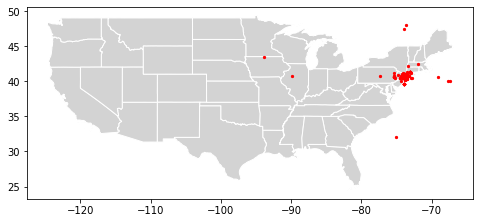

In [139]:
geometry = [Point(xy) for xy in zip(uber_usa.pickup_longitude, uber_usa.pickup_latitude)]
gdf = GeoDataFrame(uber_usa, geometry=geometry)   

states = gpd.read_file('geopandas-tutorial/data/usa-states-census-2014.shp')
gdf.plot(ax=states.plot(figsize=(8, 6), linewidth=1, edgecolor='white', color='lightgrey'), marker='o', color='red', markersize=5);

Majority of the USA coordinates are in New York or New Jersey

# Preparing for the Model

In [140]:
q_fare_amount = np.quantile(uber_usa['fare_amount'], [0,0.25,0.5,0.75,1])
print(q_fare_amount)
q_log_fare = np.quantile(uber_usa['log_fare_amount'], [0,0.25,0.5,0.75,1])
print(q_log_fare)
q_fare_per_distance = np.quantile(uber_usa['fare_per_distance'], [0,0.25,0.5,0.75,1])
print(q_fare_per_distance)
q_log_fare_per_distance = np.quantile(uber_usa['log_fare_per_distance'], [0,0.25,0.5,0.75,1])
print(q_log_fare_per_distance)

[1.00e-02 6.00e+00 8.50e+00 1.25e+01 2.30e+02]
[-4.60517019  1.79175947  2.14006616  2.52572864  5.43807931]
[  0.     4.77   6.13   8.06 963.25]
[       nan 1.5623463  1.81319475 2.08691356 6.87031298]


Determining what to bin based off the spread between the fare amount and fare rate

In [141]:
# fare_amount = uber_usa.fare_amount
log_fare_amount = uber_usa.log_fare_amount
# fare_bin = pd.qcut(fare_amount, [0.,0.33,0.66,1], labels = ["low","med","high"])
log_fare_bin = pd.qcut(log_fare_amount, [0.,0.33,0.66,1], labels = ["low","med","high"])
log_fare_bin = pd.Series(log_fare_bin, name = "log_fare_bin")
# fare_bin = pd.Series(fare_bin, name="fare_bin")
# uber_fare = pd.concat([fare_amount,fare_bin], axis=1)
uber_fare = pd.concat([log_fare_amount,log_fare_bin], axis=1)
uber_fare.head()

,log_fare_amount,log_fare_bin
0,2.014903,med
1,2.041220,med
2,2.557227,high
3,1.667707,low
4,2.772589,high


In [142]:
uber_usa = pd.concat([uber_usa, log_fare_bin], axis=1)
uber_usa.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance(mi),fare_per_distance,year,month,day_of_week,hour,log_fare_per_distance,log_fare_amount,geometry,log_fare_bin
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.045970,7.17,2015,May,Thursday,19,1.969906,2.014903,POINT (-73.99982 40.73835),med
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,1.527078,5.04,2009,Jul,Friday,20,1.617406,2.041220,POINT (-73.99435 40.72823),med
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,3.129464,4.12,2009,Aug,Monday,21,1.415853,2.557227,POINT (-74.00504 40.74077),high
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.032524,5.13,2009,Jun,Friday,8,1.635106,1.667707,POINT (-73.97612 40.79084),low
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,2.780920,5.75,2014,Aug,Thursday,17,1.749200,2.772589,POINT (-73.92502 40.74408),high


<AxesSubplot: xlabel='log_fare_bin', ylabel='count'>

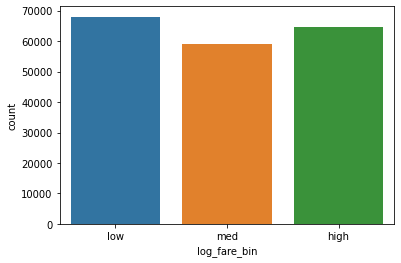

In [143]:
sns.countplot(data=uber_usa, x="log_fare_bin")

It appears the price amounts are fairly distributed

In [144]:
uber_usa.columns.tolist()

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'distance(mi)',
 'fare_per_distance',
 'year',
 'month',
 'day_of_week',
 'hour',
 'log_fare_per_distance',
 'log_fare_amount',
 'geometry',
 'log_fare_bin']

In [145]:
uber_final = uber_usa[['fare_amount','passenger_count','distance(mi)','fare_per_distance','month','day_of_week','hour','log_fare_bin']]
uber_final.head()

,fare_amount,passenger_count,distance(mi),fare_per_distance,month,day_of_week,hour,log_fare_bin
0,7.5,1,1.045970,7.17,May,Thursday,19,med
1,7.7,1,1.527078,5.04,Jul,Friday,20,med
2,12.9,1,3.129464,4.12,Aug,Monday,21,high
3,5.3,3,1.032524,5.13,Jun,Friday,8,low
4,16.0,5,2.780920,5.75,Aug,Thursday,17,high


In [146]:
uber_final.dtypes

fare_amount           float64
passenger_count         int64
distance(mi)          float64
fare_per_distance     float64
month                  object
day_of_week            object
hour                    int64
log_fare_bin         category
dtype: object

In [147]:
uber_final = uber_final.astype({'month':'category',
                   'day_of_week':'category',
                   'hour':'category'})
uber_final.dtypes

fare_amount           float64
passenger_count         int64
distance(mi)          float64
fare_per_distance     float64
month                category
day_of_week          category
hour                 category
log_fare_bin         category
dtype: object

In [148]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


In [149]:
X = uber_final.drop('log_fare_bin', axis=1)
y= uber_final['log_fare_bin']


In [150]:
X=pd.get_dummies(X)
X.head()

,fare_amount,passenger_count,distance(mi),fare_per_distance,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,7.5,1,1.045970,7.17,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,7.7,1,1.527078,5.04,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,12.9,1,3.129464,4.12,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,5.3,3,1.032524,5.13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16.0,5,2.780920,5.75,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [151]:
y

0          med
1          med
2         high
3          low
4         high
          ... 
199994    high
199996     med
199997    high
199998    high
199999    high
Name: log_fare_bin, Length: 191601, dtype: category
Categories (3, object): ['low' < 'med' < 'high']

In [152]:
print(X.shape)
print(y.shape)

(191601, 47)
(191601,)


In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [154]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(153280, 47) (153280,)
(38321, 47) (38321,)


In [155]:
scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [156]:
X_train_norm

array([[1.23076923e-02, 0.00000000e+00, 8.80804341e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.46153846e-02, 8.00000000e-01, 1.00443439e-03, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [5.71428571e-02, 0.00000000e+00, 8.18655160e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.63736264e-02, 0.00000000e+00, 1.90477042e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.81318681e-02, 0.00000000e+00, 4.16402878e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53846154e-02, 0.00000000e+00, 7.42620762e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

# Feature Dimension Reduction by LDA on Uber Data

In [157]:
y.unique()

['med', 'high', 'low']
Categories (3, object): ['low' < 'med' < 'high']

There are three labels in the target variable

In [158]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_norm_lda = lda.fit_transform(X_train_norm, y_train)
X_test_norm_lda = lda.transform(X_test_norm)

In [159]:
X_train_norm_lda.shape, X_test_norm_lda.shape

((153280, 2), (38321, 2))

In [160]:
lda.explained_variance_ratio_

array([0.99532202, 0.00467798])

majority of the variance is in the first component

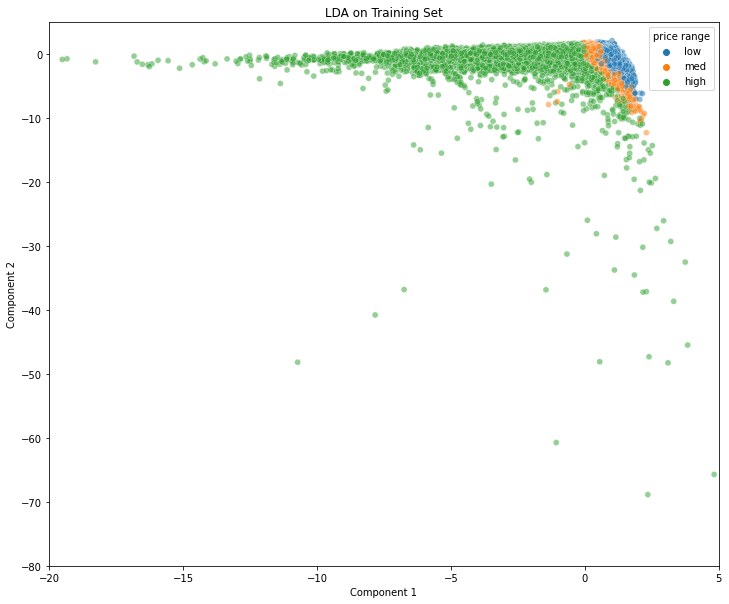

In [190]:
plt.figure(figsize =(12,10))
sns.scatterplot(data = X_train_norm_lda,x= X_train_norm_lda[:, 0],y= X_train_norm_lda[:, 1],
                 hue=y_train, alpha = 0.5)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("LDA on Training Set")
plt.xlim([-20, 5])
plt.ylim([-80, 5])
plt.legend(title = "price range")
plt.show()

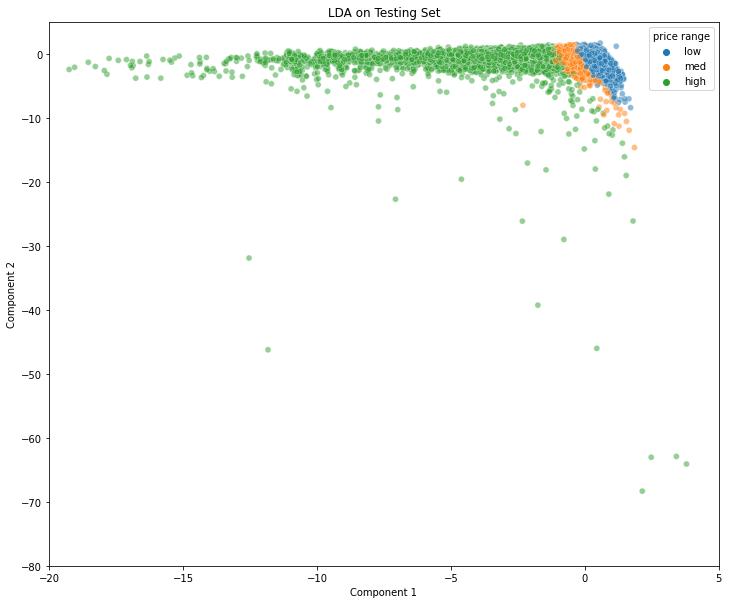

In [189]:
plt.figure(figsize =(12,10))
sns.scatterplot(data =X_test_norm_lda, x=X_test_norm_lda[:, 0], y=X_test_norm_lda[:, 1], hue = y_test,
                alpha = 0.5 )
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("LDA on Testing Set")
plt.xlim([-20, 5])
plt.ylim([-80, 5])
plt.legend(title = "price range")
plt.show()

These 2 components are separated well within classes there are only a few that overlap between classes

### Apply the Logistic Regression Model on the 2 components

In [163]:
from sklearn.linear_model import LogisticRegression

In [164]:
lg = LogisticRegression()
lg.fit(X_train_norm_lda, y_train)
pred_train_lda = lg.predict(X_train_norm_lda)
pred_test_lda = lg.predict(X_test_norm_lda)

In [165]:
print(metrics.classification_report(y_train, pred_train_lda))
print(metrics.classification_report(y_test, pred_test_lda))

              precision    recall  f1-score   support

        high       0.96      0.95      0.95     51722
         low       0.91      0.92      0.92     54394
         med       0.85      0.85      0.85     47164

    accuracy                           0.91    153280
   macro avg       0.91      0.91      0.91    153280
weighted avg       0.91      0.91      0.91    153280

              precision    recall  f1-score   support

        high       0.43      1.00      0.60     12947
         low       1.00      0.03      0.06     13590
         med       0.00      0.00      0.00     11784

    accuracy                           0.35     38321
   macro avg       0.48      0.34      0.22     38321
weighted avg       0.50      0.35      0.22     38321



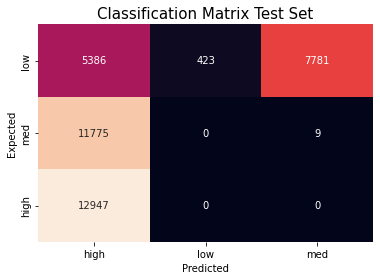

In [166]:
confusion_matrix(y_test, pred_test_lda)

# Apply Logistic Regression Model on original Features

In [167]:
lg = LogisticRegression()
lg.fit(X_train_norm, y_train)
pred_train_lg = lg.predict(X_train_norm)
pred_test_lg = lg.predict(X_test_norm)

In [168]:
print(metrics.classification_report(y_train, pred_train_lg))
print(metrics.classification_report(y_test, pred_test_lg))

              precision    recall  f1-score   support

        high       1.00      0.93      0.96     51722
         low       0.92      1.00      0.96     54394
         med       0.92      0.90      0.91     47164

    accuracy                           0.95    153280
   macro avg       0.95      0.94      0.94    153280
weighted avg       0.95      0.95      0.95    153280

              precision    recall  f1-score   support

        high       0.44      1.00      0.61     12947
         low       1.00      0.02      0.04     13590
         med       0.00      0.00      0.00     11784

    accuracy                           0.34     38321
   macro avg       0.48      0.34      0.21     38321
weighted avg       0.50      0.34      0.22     38321



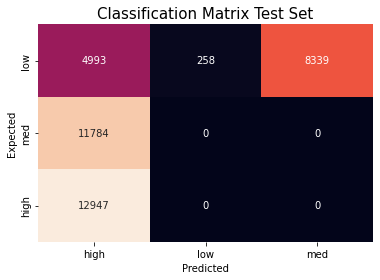

In [169]:
confusion_matrix(y_test, pred_test_lg)

In [170]:
print(f"The test accuracy with LDA is: {metrics.accuracy_score(y_test, pred_test_lda)*100}")
print(f"The test accuracy without LDA is: {metrics.accuracy_score(y_test, pred_test_lg)*100}")

The test accuracy with LDA is: 34.91297199968685
The test accuracy without LDA is: 34.45891286761828


Using the LDA components on this dataset resulted in an increase by about 1%, however the overall performance is still low

# Using LDA as a Classification Algorithm

### Simple LDA Model

In [171]:
ldclf = LinearDiscriminantAnalysis()
ldclf.fit(X_train_norm, y_train)
pred_train = ldclf.predict(X_train)
pred_test = ldclf. predict(X_test)

In [172]:
print(metrics.classification_report(y_train, pred_train))
print(metrics.classification_report(y_test, pred_test))

              precision    recall  f1-score   support

        high       0.42      0.99      0.59     51722
         low       0.87      0.52      0.65     54394
         med       0.00      0.00      0.00     47164

    accuracy                           0.52    153280
   macro avg       0.43      0.50      0.41    153280
weighted avg       0.45      0.52      0.43    153280

              precision    recall  f1-score   support

        high       0.42      0.99      0.59     12947
         low       0.87      0.51      0.65     13590
         med       0.00      0.00      0.00     11784

    accuracy                           0.52     38321
   macro avg       0.43      0.50      0.41     38321
weighted avg       0.45      0.52      0.43     38321



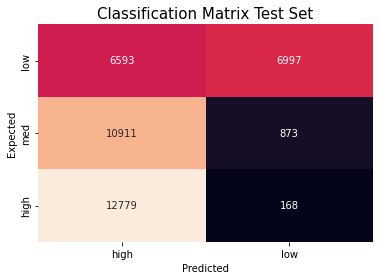

In [173]:
confusion_matrix(y_test, pred_test)

Using a simple LDA model did not perform so well in terms of accuracy on the test data, but we will try and get a better result using GridSearchCV

# LDA with Random Forest Feature Importance and Tuning

In [174]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()


In [175]:
rfclf.fit(X_train_norm, y_train)
pred_rf_train = rfclf.predict(X_train_norm)
pred_rf_test = rfclf.predict(X_test_norm)

In [176]:
def plot_feature_importances(model, n_features, feature_names):
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

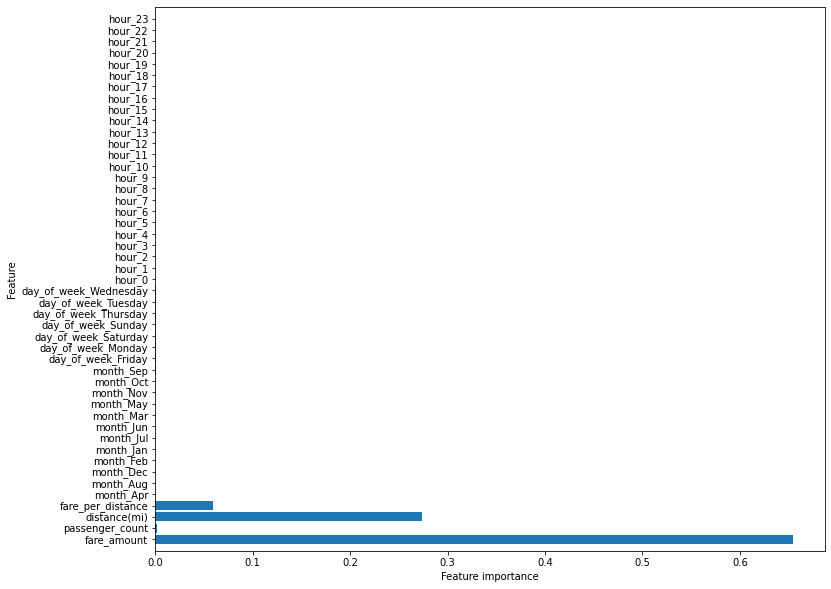

In [177]:
features = X_train.columns.tolist()
plt.figure(figsize =(12,10))
plot_feature_importances(rfclf, len(features), features)

The point in time variables appears to be not important they will be removed and another LDA model will be created

In [178]:
X_train_rf = X_train[['fare_amount','fare_per_distance','distance(mi)','passenger_count']]
X_test_rf = X_test[['fare_amount','fare_per_distance','distance(mi)','passenger_count']]

In [179]:
X_train_rf_norm = scaler.fit_transform(X_train_rf)
X_test_rf_norm = scaler.fit_transform(X_test_rf)

In [180]:
parameters = {
    "solver":["svd","lsqr", "eigen"],
    "shrinkage": ["auto","float"]
}

gs = GridSearchCV(ldclf, parameters, scoring ="accuracy", cv=3, n_jobs=-1)

In [181]:
gs.fit(X_train_rf_norm, y_train)

GridSearchCV(cv=3, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'shrinkage': ['auto', 'float'],
                         'solver': ['svd', 'lsqr', 'eigen']},
             scoring='accuracy')

In [182]:
gs.best_params_

{'shrinkage': 'auto', 'solver': 'lsqr'}

In [183]:
pred_train_best = gs.predict(X_train_rf_norm)
pred_test_best =gs.predict(X_test_rf_norm)

In [184]:
print(metrics.classification_report(y_train, pred_train_best))
print(metrics.classification_report(y_test, pred_test_best))

              precision    recall  f1-score   support

        high       1.00      0.62      0.76     51722
         low       0.69      1.00      0.82     54394
         med       0.55      0.50      0.52     47164

    accuracy                           0.72    153280
   macro avg       0.75      0.71      0.70    153280
weighted avg       0.75      0.72      0.71    153280

              precision    recall  f1-score   support

        high       0.61      1.00      0.76     12947
         low       0.95      0.43      0.59     13590
         med       0.30      0.28      0.29     11784

    accuracy                           0.58     38321
   macro avg       0.62      0.57      0.55     38321
weighted avg       0.64      0.58      0.55     38321



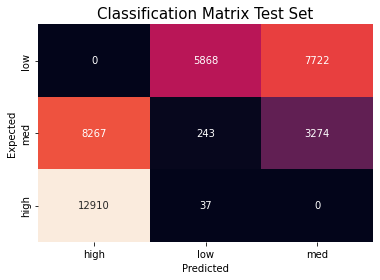

In [185]:
confusion_matrix(y_test, pred_test_best)